# 

## TODO: 

1. Split into train/validation/test data
2. Construct a testing apperatus. At minimum measure accuracy. Probably also things like F1. Maybe make a function which produces a list of the predicted labels along with a list of the true labels for comparison purposes?
3. Optimize model parameters
4. Test random/trained weights against pretrained/finetuned Alexnet weights.
5. Make code more efficient? Interestingly, at least when I run it on Kaggle with the GPU T4 x2, CPU is the bottleneck. Not GPU. Very possible that CPU related code can be improved/the model can be made to train a decent bit faster.
6. Organize/neaten up the notebook
7. Split notebook? Into one for training/saving the model and one for loading/testing it.
8. Notebook has run out of memory/restarted before. If persistent issue, find a fix.
9. Model doesn't currently seem to be training. Loss is jumping back and forth in a certain range. Fix/make sure model is training. (Could potentially also be an issue with the dataset/labels/how I load them. Possible path to check if everything looks fine model side.)

In [1]:
import torch
from torchvision.transforms import v2 # PyTorch image transformations
from PIL import Image # pillow library for opening images

import matplotlib.pyplot as plt

In [2]:
def get_transform(mode:str):

    if mode == "base":
        # Without Augmentations
        transform = v2.Compose([
            v2.ToDtype(torch.float32, scale=True), 
        	v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])

    elif mode == "augmented":
        # With Augmentations
        transform = v2.Compose([
            v2.ToDtype(torch.float32, scale=True),
        
            # flip image
            v2.RandomHorizontalFlip(p=0.5),
        	v2.RandomVerticalFlip(p=0.5),
        
            # rotate image by 90 degrees 0, 1, 2, or 3 times
            v2.RandomChoice([
                v2.Lambda(lambda image: torch.rot90(image, 0, [1, 2])), # 90 degrees 
                v2.Lambda(lambda image: torch.rot90(image, 1, [1, 2])), # 90 degrees 
                v2.Lambda(lambda image: torch.rot90(image, 2, [1, 2])), # 180 degrees
                v2.Lambda(lambda image: torch.rot90(image, 3, [1, 2])), # 270 degrees
            ]),
        
        	v2.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

    else: 
        raise NotImplementedError

    return transform

In [3]:
import random
random.seed(12345)

In [4]:
import os

In [5]:
def get_tot_files(main_dir):
    tot_len = 0
    for a_dir in os.walk(main_dir):
        tot_len = tot_len + len(a_dir[2])
    return tot_len

In [6]:
from torch.utils.data import Dataset


In [7]:
from torchvision.io import read_image

class CustomDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.total_imgs = get_tot_files(main_dir)
        self.healthy_imgs = get_tot_files(main_dir + "/Healthy")
        self.transform = transform
        self.main_dir = main_dir

    def __len__(self):
        return self.total_imgs

    def __getitem__(self, idx):
        if idx < self.healthy_imgs:
            label = 0
            sub_dir = "Healthy"
            pos = idx
        else:
            label = 1
            sub_dir = "Anemic"
            pos = idx - self.healthy_imgs
        
        img_dir = os.path.join(self.main_dir, sub_dir)
        img_name = next(os.walk(img_dir))[2][pos]
        img_path = os.path.join(img_dir, img_name)
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [8]:
from torch.utils.data import DataLoader

In [9]:
device = ("cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu")
print(f"Using {device} device.")

Using cuda device.


In [10]:
labels_map = {
    0: "Healthy",
    1: "Anemic"
}

In [11]:
my_batch_size=16
my_epochs = 10
my_lr = 1e-3

In [12]:
dataset_path = "/kaggle/input/anemic-rbc-dataset-resized/Anemic_RBC_dataset_resized/"
training_data = CustomDataset(dataset_path,  get_transform("augmented"))
train_dataloader = DataLoader(training_data, shuffle=True, batch_size=my_batch_size, num_workers=3)

In [13]:
from tqdm import tqdm

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Alexnet(nn.Module):
    def __init__(self):
        super(Alexnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 16, 3)
        self.flat1 = nn.Flatten()
        self.dense1 = nn.Linear(14400, 256)
        self.dense2 = nn.Linear(256, 1)

        self.pool1 = nn.MaxPool2d(2)
        self.pool2 = nn.MaxPool2d(2)
        self.pool3 = nn.MaxPool2d(2)
    def forward(self, z):
        out = F.relu(self.conv1(z))
        out = self.pool1(out)
        out = F.relu(self.conv2(out))
        out = self.pool2(out) 
        out = F.relu(self.conv3(out))
        out = self.pool3(out)  
        out = self.flat1(out)
        out = F.relu(self.dense1(out))
        out = F.sigmoid(self.dense2(out))
        return out

In [15]:
import torch.optim as optim


In [16]:
def training_loop(dataloader, num_epochs, device="cpu", batch_size=16,
                  optimizer=optim.AdamW, loss_fn=nn.BCELoss(), print_loss=True, lr=.001):
    iter_list = []
    an_loss_list = []
    
    an_model = Alexnet().to(device)
    an_model.train()

    an_optimizer = optimizer(an_model.parameters(), lr=lr)
    
    iteration = 0
    for epoch in tqdm(range(num_epochs)):
        for data, labels in dataloader:
            images = data.to(device)
            labels = labels.to(device)

            an_loss = loss_fn(an_model(images)[:, 0], labels.float())

            an_loss.backward()
            an_optimizer.step()

            if (iteration+1) % 200 == 0:
                iter_list.append(iteration)
                an_loss_list.append(an_loss)
    
                if print_loss:
                    print(f"Iteration {iteration} during epoch {epoch}")
                    print(f"Alexnet loss: {an_loss}")
        
            iteration += 1

        if (epoch+1) % 5 == 0: 
            # Save the model every 5 epochs
            torch.save(an_model.state_dict(), f'an_model_weights_{epoch}_{lr}.pth')

    return iter_list, an_loss_list

In [17]:
iter_list, an_loss_list = training_loop(train_dataloader, num_epochs=1, batch_size=my_batch_size,
                                        lr=my_lr, device=device, print_loss = True)

  0%|          | 0/1 [00:00<?, ?it/s]

Iteration 199 during epoch 0
Alexnet loss: 0.6977301836013794
Iteration 399 during epoch 0
Alexnet loss: 0.6913131475448608
Iteration 599 during epoch 0
Alexnet loss: 0.7119641304016113


100%|██████████| 1/1 [01:45<00:00, 105.99s/it]


In [18]:
an_loss_list = torch.tensor(an_loss_list, device="cpu")

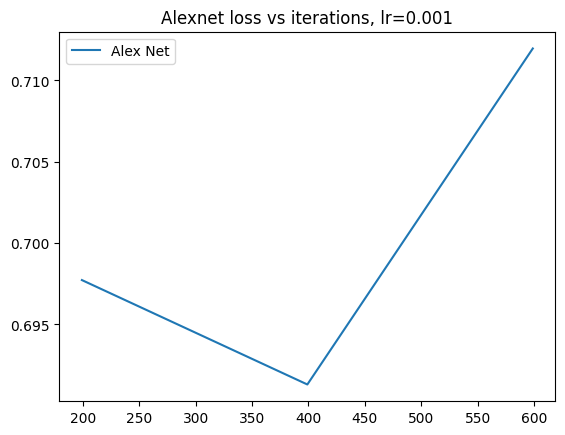

In [19]:
# Plotting generator and discriminator loss vs iterations
plt.plot(iter_list, an_loss_list, label="Alex Net")
plt.title(f"Alexnet loss vs iterations, lr={my_lr}")
plt.legend()
plt.show()

In [20]:
epoch = 9

model = Alexnet()
model.load_state_dict(torch.load(f"an_model_weights_{epoch}_{my_lr}.pth", weights_only=True))

<All keys matched successfully>

In [21]:
model.eval()

Alexnet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (flat1): Flatten(start_dim=1, end_dim=-1)
  (dense1): Linear(in_features=14400, out_features=256, bias=True)
  (dense2): Linear(in_features=256, out_features=1, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [22]:
import sklearn.metrics as metrics

In [42]:
def results_list(model, dataloader, device="cpu"):
    pred_results = []
    true_results = []
    
    for data, labels in tqdm(dataloader):
        results = model(data)
        
        for i in range(len(data)):
            pred_results.append(results[i].detach().clone())
            true_results.append(labels[i].detach().clone())

    for i in range(len(pred_results)):
        if pred_results[i] >.5:
            pred_results[i] = 1
        else:
            pred_results[i] = 0
    
    return pred_results, true_results

In [43]:
pred, truth = results_list(model, train_dataloader, device) ### Need to implement bringing stuff to the GPU while in results_list()

100%|██████████| 753/753 [02:40<00:00,  4.69it/s]


In [44]:
pred = torch.tensor(pred, device="cpu")

In [45]:
next(model.parameters()).device

device(type='cpu')

In [46]:
metrics.accuracy_score(pred, truth)

0.5001246157680486

# OLD / must be modified to work if we want to keep it.

In [ ]:
test_image = Image.open(data_path)

In [ ]:
transformed_test_image = transforms_augmented(test_image)
v2.ToPILImage(transformed_test_image)

# convert from (C, H, W) to (H, W, C) for displaying in matplotlib
img_np = transformed_test_image.permute(1, 2, 0).numpy()

# display augmented image
plt.imshow(img_np)
plt.axis('off')
plt.show()